In [3]:
%load_ext autoreload
%autoreload 2
%autoawait trio
%matplotlib inline

import trio
import pyfuse3
import src
import logging
import matplotlib
import matplotlib.pyplot as plt
import IPython

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense
from sklearn.manifold import *
from sklearn.feature_extraction.text import CountVectorizer
from src.runner import Runner
from src.mock_runner import MockRunner
from src.env import Env
from src.stats.post import *
import src.methods
import pandas as pd
from pandas import read_csv, DataFrame
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_colwidth', 250)

In [4]:
df1 = read_csv('soykb30min')
df = read_csv('traces/wf1')
# df3 = read_csv('df_clusters')

df1_filenames = [f for f in set(df1.filename) if '.tmp' not in f and 'gatk-output' not in f and '20180321' not in f and '.log' not in f]
df1_labels = [f in df1_filenames for f in set(df1.filename)]

In [5]:
filenames = list(set(df1.filename)) # + list(set(df2.filename)) + list(set(df3.filename))
max_path_len = max(map(len, set(filenames)))
in_paths = np.array(filenames)
labels = np.array(df1_labels) # + [True] * (len(set(df2.filename)) + len(set(df3.filename))))

In [9]:
from sklearn.decomposition import TruncatedSVD

def files_to_vec_df(in_paths, shouldPrefetch=None, components=2):
    cv = CountVectorizer(analyzer='char')
    X = cv.fit_transform(in_paths)
    svd = TruncatedSVD(n_components=components)
    x_svd = svd.fit_transform(X)
    dfn = DataFrame()
    dfn["filename"] = in_paths
    dfn["x0"] = x_svd[:, 0]
    dfn["x1"] = x_svd[:, 1]
    dfn["shouldPrefetch"] = shouldPrefetch
    return dfn

def plot(dfn):
    plt.figure(figsize=(12, 8))
    plt.scatter(dfn[dfn.shouldPrefetch].x0, dfn[dfn.shouldPrefetch].x1, c='red', s=2)
    plt.scatter(dfn[dfn.shouldPrefetch == False].x0, dfn[dfn.shouldPrefetch == False].x1, c='blue', s=0.1)
    plt.show()

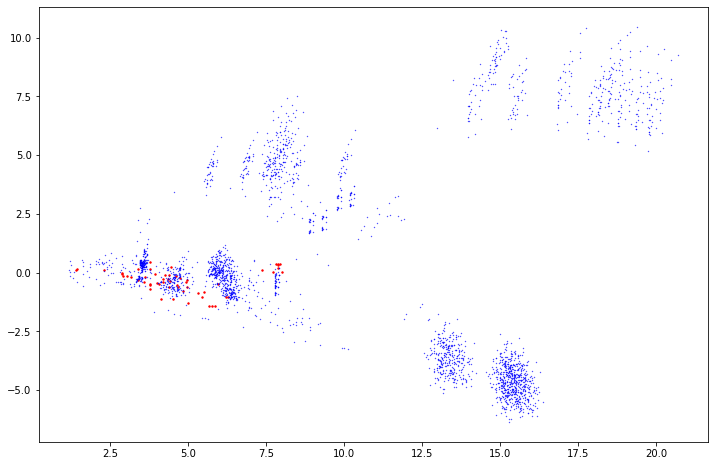

In [10]:
import subprocess
import re
result = subprocess.run(['find', '.'], stdout=subprocess.PIPE)
all_files = result.stdout.decode().split()[1:]

re_lambda = lambda x: (re.match('.*\.py$', x) or re.match('.*Gmax', x)) and True or False

all_files_labels = list(map(re_lambda, all_files))
dfn = files_to_vec_df(all_files, all_files_labels)
plot(dfn)

In [11]:
df_sk = read_csv('soykb30min')

sp = lambda f: '.tmp' not in f and 'gatk-output' not in f and '20180321' not in f and '.log' not in f
df_sk["shouldPrefetch"] = df_sk.filename.map(sp)
df_sk.offset = df_sk.offset * 1024
df_sk.end = df_sk.end * 1024
df_sk

,Unnamed: 0,end,filename,kind,length,offset,pid,timestamp,shouldPrefetch
0,0,52638.0,./sources/soykb/workflow.json,Miss,52638.0,0.0,234538.0,0.000000,True
1,1,978495356.0,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,380.0,978494976.0,234602.0,1.911958,True
2,2,512.0,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,512.0,0.0,234602.0,1.916361,True
3,3,1048600.0,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,1048088.0,512.0,234602.0,1.921081,True
4,4,2097176.0,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,1048576.0,1048600.0,234602.0,1.929564,True
...,...,...,...,...,...,...,...,...,...
82272,82272,462110347.0,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,461979275.0,248522.0,1797.561050,True
82273,82273,462241419.0,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,462110347.0,248522.0,1797.574653,True
82274,82274,462372491.0,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,462241419.0,248522.0,1797.593539,True
82275,82275,462503563.0,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,462372491.0,248522.0,1797.612694,True


In [ ]:
# słownik filename->wektor
import subprocess
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

def files_to_vec_df(in_paths, components=2):
    cv = CountVectorizer(analyzer='char')
    X = cv.fit_transform(in_paths)
    svd = TruncatedSVD(n_components=components)
    x_svd = svd.fit_transform(X)
    dfn = DataFrame()
    dfn["filename"] = in_paths
    for xn in range(components):
        dfn["x" + str(xn)] = x_svd[:, xn]
    return dfn

result = subprocess.run(['find', '.'], stdout=subprocess.PIPE)
all_files = list(set(result.stdout.decode().split()[1:]) | set(df_sk.filename))

df_vec = files_to_vec_df(all_files, 2)
vec_dict = df_vec.set_index('filename').to_dict()
vec_dict

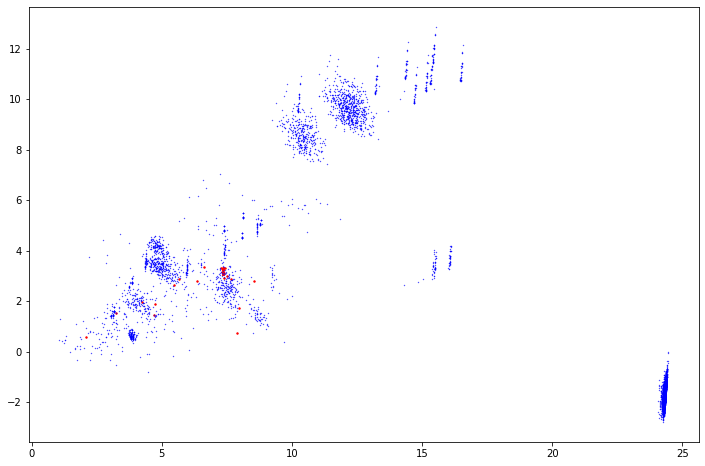

In [13]:
x = df_vec.copy()
x["shouldPrefetch"] = x.filename.map(lambda filename: sp(filename) and 'soykb' in filename)
plot(x)

In [ ]:
# słownik filename->wektor
import subprocess
import re
from sklearn.manifold import TSNE

def files_to_vec_df_tsne(in_paths, components=2):
    cv = CountVectorizer(analyzer='char')
    X = cv.fit_transform(in_paths)
    tsne = TSNE(n_components=components)
    x_tsne = tsne.fit_transform(X)
    dfn = DataFrame()
    dfn["filename"] = in_paths
    for xn in range(components):
        dfn["x" + str(xn)] = x_tsne[:, xn]
    return dfn

result = subprocess.run(['find', '.'], stdout=subprocess.PIPE)
all_files = list(set(result.stdout.decode().split()[1:]) | set(df_sk.filename))

df_vec = files_to_vec_df_tsne(all_files, 2)
vec_dict = df_vec.set_index('filename').to_dict()

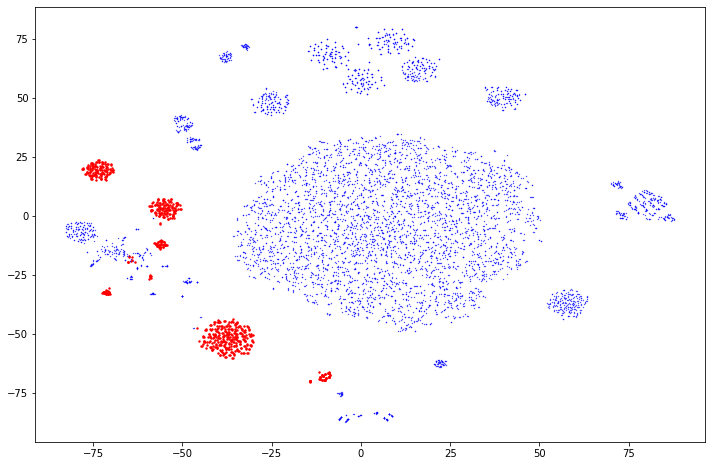

In [51]:
x = df_vec.copy()
x["shouldPrefetch"] = x.filename.map(lambda filename: sp(filename) and 'sources' in filename)
plot(x)

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True) # don't use scientific notation

In [62]:
df_vec = files_to_vec_df(all_files, 3)
vec_dict = df_vec.set_index('filename').to_dict()

In [64]:
components = len(vec_dict.keys())
columns = ["x" + str(n) for n in range(components)]
x = df_vec.copy()
x["shouldPrefetch"] = x.filename.map(lambda filename: sp(filename) and 'soykb' in filename)
cmats = []
for _ in range(100):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    split = int(len(idx) * 0.5)
    train, test = idx[:split], idx[split:]
    x_train, x_test = x.loc[train], x.loc[test]

    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(x_train[columns], x_train["shouldPrefetch"])
    y_pred = tree.predict(x_test[columns])
    cmats.append(confusion_matrix(x_test["shouldPrefetch"], y_pred))
cmats = np.array(cmats).mean(axis=0)
print(cmats)

SyntaxError: invalid syntax (<ipython-input-64-c330c87f3404>, line 1)

In [1]:
df_zip = read_csv('traces/zip')
len(set(df_zip.offset))

NameError: name 'read_csv' is not defined

In [59]:
from os.path import getsize
from functools import lru_cache
@lru_cache
def safe_getsize(f):
    try:
        return getsize(f)
    except FileNotFoundError:
        return 1024

sp = lambda f: 'soykb' in f and ('.tmp' not in f and 'gatk-output' not in f and '20180321' not in f and '.log' not in f)
repeats=10

components = 2
x = files_to_vec_df(in_paths, components=components)
x["shouldPrefetch"] = x.filename.map(sp)
errors = []
arange = np.arange(0.02, 0.7, 0.04)
for percent in arange:
    cmats = []
    for _ in range(repeats):
        idx = np.arange(len(x))
        np.random.shuffle(idx)
        split = int(len(idx) * percent)
        train, test = idx[:split], idx[split:]
        x_train, x_test = x.loc[train], x.loc[test]

        tree = DecisionTreeClassifier()
        cols = [f"x{i}" for i in range(components)]
        tree.fit(x_train[cols], x_train["shouldPrefetch"])
        y_pred = tree.predict(x_test[cols])
        cmats.append(confusion_matrix(x_test["shouldPrefetch"], y_pred))
    cmats = np.array(cmats).mean(axis=0)
    errors.append(cmats[1, 0]+cmats[0, 1])

components = 5
x = files_to_vec_df(in_paths, components=components)
x["shouldPrefetch"] = x.filename.map(sp)
x["filesize"] = x.filename.map(safe_getsize)
errors_5c = []
for percent in arange:
    cmats = []
    for _ in range(repeats):
        idx = np.arange(len(x))
        np.random.shuffle(idx)
        split = int(len(idx) * percent)
        train, test = idx[:split], idx[split:]
        x_train, x_test = x.loc[train], x.loc[test]

        tree = DecisionTreeClassifier()
        cols = [f"x{i}" for i in range(components)]
        cols += ["filesize"]
        tree.fit(x_train[cols], x_train["shouldPrefetch"])
        y_pred = tree.predict(x_test[cols])
        cmats.append(confusion_matrix(x_test["shouldPrefetch"], y_pred))
    cmats = np.array(cmats).mean(axis=0)
    errors_5c.append(cmats[1, 0]+cmats[0, 1])



components = 2
x = files_to_vec_df(in_paths, components=components)
x["shouldPrefetch"] = x.filename.map(sp)
x["filesize"] = x.filename.map(safe_getsize)
errors_with_size = []
for percent in arange:
    cmats = []
    for _ in range(repeats):
        idx = np.arange(len(x))
        np.random.shuffle(idx)
        split = int(len(idx) * percent)
        train, test = idx[:split], idx[split:]
        x_train, x_test = x.loc[train], x.loc[test]

        tree = DecisionTreeClassifier()
        cols = [f"x{i}" for i in range(components)]
        cols += ["filesize"]
        tree.fit(x_train[cols], x_train["shouldPrefetch"])
        y_pred = tree.predict(x_test[cols])
        cmats.append(confusion_matrix(x_test["shouldPrefetch"], y_pred))
    cmats = np.array(cmats).mean(axis=0)
    errors_with_size.append(cmats[1, 0]+cmats[0, 1])
        tree = DecisionTreeClassifier()
        cols = [f"x{i}" for i in range(components)]
        cols += ["filesize"]
        tree.fit(x_train[cols], x_train["shouldPrefetch"])
        y_pred = tree.predict(x_test[cols])
        cmats.append(confusion_matrix(x_test["shouldPrefetch"], y_pred))
    cmats = np.array(cmats).mean(axis=0)
    errors_with_size.append(cmats[1, 0]+cmats[0, 1])
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
plt.plot(arange, errors, c='red')
plt.plot(arange, errors_with_size, c='green')
plt.plot(arange, errors_5c, c='blue')

IndentationError: unexpected indent (<ipython-input-59-431221eff29e>, line 82)

In [60]:
cmats.sum()

AttributeError: 'list' object has no attribute 'sum'

In [61]:
components = 2
errors = []
for percent in np.arange(0.02, 0.9, 0.04):
    cmats = []
    for _ in range(5):
        idx = np.arange(len(x))
        np.random.shuffle(idx)
        split = int(len(idx) * percent)
        train, test = idx[:split], idx[split:]
        x_train, x_test = x.loc[train], x.loc[test]

        tree = DecisionTreeClassifier()
        cols = [f"x{i}" for i in range(components)]
        tree.fit(x_train[["x0", "x1"]], x_train["shouldPrefetch"])
        y_pred = tree.predict(x_test[["x0", "x1"]])
        cmats.append(confusion_matrix(x_test["shouldPrefetch"], y_pred))
    cmats = np.array(cmats).mean(axis=0)
    errors.append(cmats[1, 0]+cmats[0, 1])
plt.figure(figsize=(12,6))
plt.plot(np.arange(0.02, 0.9, 0.04), errors)

NameError: name 'confusion_matrix' is not defined

In [62]:
dtc = od.methods.dtc.Dtc(df=df_sk, vec_dict=vec_dict)
dtc.train(training_split=0.4)
env = Env('soykb').cache(float('inf'))

df_mock = MockRunner(predictor=dtc, env=env).run(df_sk, limit_df=50000)

TypeError: __init__() got an unexpected keyword argument 'df'

In [63]:
draw_reads(df_mock[df_mock.source != 'prefetch'])

NameError: name 'df_mock' is not defined

In [778]:
df_mock

,filename,offset,length,pid,end,timestamp,source,full_read,hit,kind
0,./sources/soykb/workflow.json,0.0,52638.0,234538.0,52638.0,1.621234e+09,read,False,False,Miss
1,./sources/soykb/workflow.json,0.0,52638.0,234538.0,52638.0,1.621234e+09,prefetch,True,True,Prefetch
2,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,978494976.0,380.0,234602.0,978495356.0,1.621234e+09,read,False,False,Miss
3,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,0.0,978495356.0,234602.0,978495356.0,1.621234e+09,prefetch,True,False,Prefetch
4,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,0.0,512.0,234602.0,512.0,1.621234e+09,read,False,True,Hit
...,...,...,...,...,...,...,...,...,...,...
85850,./sources/soykb/input/Gmax_275_v2.0.fa,0.0,990744229.0,248522.0,990744229.0,1.621235e+09,prefetch,True,True,Prefetch
85851,./sources/soykb/input/Gmax_275_v2.0.fa,62866678.0,131072.0,248522.0,62997750.0,1.621235e+09,read,False,True,Hit
85852,./sources/soykb/input/Gmax_275_v2.0.fa,0.0,990744229.0,248522.0,990744229.0,1.621235e+09,prefetch,True,True,Prefetch
85853,./sources/soykb/input/org.broadinstitute.sting.gatk.io.stubs.VariantContextWriterStub7443713589727237527.tmp,0.0,18.0,249432.0,18.0,1.621235e+09,read,False,True,Hit


In [805]:
predictor_stats(df_mock)

Cache hit rate     	 0.8759
Prefetch usage rate	 0.004852879654162599


In [869]:
df_mock.hit.value_counts()

True     79640
False     6215
Name: hit, dtype: int64